In [1]:
import torch
import os
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pandas as pd

from model.classifier import Net as ClassNet
from torch.utils.data import Dataset, TensorDataset, DataLoader

trained_class = '../result/gpu_classification_g3train.pt'
class_model = ClassNet()
class_model.load_state_dict(torch.load(trained_class, map_location=torch.device('cuda')))
class_model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_model = class_model.double()
class_model.to(device)

print("Model Loaded")

print("Importing Data")

/tmpscratch/tkim12/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model Loaded
Importing Data


In [3]:
# Load Sky map
path="/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/quicklens_720x720/"
pathsig = '/afs/crc.nd.edu/user/t/tkim12/Work/CMB_ML/Data/Nside1024/test_img/'

bkg_only = np.empty((0, 720, 720))
sig_only = np.empty((0, 720, 720))

for evnts in range(10):
    temp = np.load(path+"500_events_720Sqr_lensed_uncutBackgroundlmax3500_"+str(evnts)+".npy")
    bkg_only = np.concatenate((bkg_only,temp))

for evnts in range(3):
    temp2 = np.load(pathsig+"sig_larger/100_PHS_720sq_g1_Sig_onLSS_"+str(evnts+1)+".npy")
    sig_only = np.concatenate((sig_only,temp2))

steps = 5

Xlowermax = int((bkg_only[0].T.shape[0]-90)/steps)*steps
Ylowermax = int((bkg_only[0].T.shape[1]-90)/steps)*steps

print(bkg_only[0].shape)
print(Xlowermax,Ylowermax)

KeyboardInterrupt: 

In [ ]:
# Implant PHS information

num_HS = 1
g_rescale = 4

In [4]:
all_pred = []
sampled_sig = []

for evnt_num in range(bkg_only.shape[0]):
#for evnt_num in range(2):
    
    print("\n\nEvent number = "+str(evnt_num+1)+"\n")
    
    if g_rescale != 0:
        sampling = torch.randperm(len(sig_only))[:num_HS].numpy()
        sampled_sig.append(sampling)
        
        sigs = np.zeros((bkg_only[0].shape[0],bkg_only[0].shape[1]))

        for ii in range(len(sampling)):
            sigs += sig_only[sampling[ii]]
    
        tot = bkg_only[evnt_num]+g_rescale*sigs
    
    elif g_rescale == 0:
        tot = bkg_only[evnt_num]
    
    i=0
    pred_outputs = []
    pred_box_loc = []
    pred_box_val = []
    boundary_box = []
    
    temp_pred = []
    X_data = []
    Y_data = []
    
    for xlower in range(int(Xlowermax/steps+1)):

        for ylower in range(int(Ylowermax/steps+1)):

            temp = (tot)[xlower*steps:(xlower*steps+90),ylower*steps:(ylower*steps+90)]

            #print("Boundary : X = ("+str(xlower*10)+", "+str(xlower*10+180)+")  
            #                        Y = ("+str(ylower*10)+", "+str(ylower*10+180)+")")

            boundary_box.append([xlower*steps, xlower*steps+90, ylower*steps, ylower*steps+90])

            X_data.append(temp)
            Y_data.append(0)



    X_data = np.array(X_data)
    print(X_data.shape)
    Y_data = np.array(Y_data)

    wid, hei = X_data.shape[1], X_data.shape[2]

    X_test = X_data.reshape(X_data.shape[0], 1, wid, hei).astype('float64')
    X_test = torch.from_numpy(X_test)

    Y_test = Y_data.reshape(Y_data.shape[0], 1).astype('float64')
    Y_test = torch.from_numpy(Y_test)

    print("Testing samples : "+str(X_test.shape[0]))
    
    test_data = TensorDataset(X_test, Y_test)

    testloader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)


    print("Prediction ... ")

    jj = 0



    with torch.no_grad():
        for data in testloader:

            images, y = data
            images, y = images.to(device), y.to(device)
            coutputs = class_model(images)
            #print(coutputs[0][0].round().detach().cpu().numpy())
            temp_pred.append(coutputs.detach().cpu().numpy())

            if coutputs[0][0].round().detach().cpu().numpy() == 1:
                pred_box_loc.append(boundary_box[i])
                pred_box_val.append(coutputs[0][0].detach().cpu().numpy())
                #print(coutputs[0][0].detach().cpu().numpy(),boundary_box[i])

            if jj%10000==0:
                print("Event : "+str(jj)+" Completed")

            jj+=1
            i+=1
        #print("xlower = "+str(xlower))
    print("Prediction done")

    temp_pred = np.concatenate(temp_pred)
    #print(temp_pred)

    all_pred.append(temp_pred.T[0])
    #print(np.array(pred_outputs).shape)
    #print(np.array(pred_box_val).shape)
    #print(np.array(pred_box_loc).shape)


all_pred = np.array(all_pred)
sampled_sig = np.array(sampled_sig)



Event number = 1

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 2

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 3

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 4

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 5

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 6

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 7

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 8

(16129, 90, 90)
Testing samp

Prediction done


Event number = 61

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 62

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 63

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 64

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 65

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 66

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 67

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 68

(161

Event : 10000 Completed
Prediction done


Event number = 121

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 122

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 123

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 124

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 125

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 126

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 127

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 181

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 182

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 183

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 184

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 185

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 186

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 187

(16129, 90, 90)
Testing samples : 

Event : 10000 Completed
Prediction done


Event number = 240

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 241

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 242

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 243

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 244

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 245

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 246

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 300

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 301

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 302

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 303

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 304

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 305

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 306

(16129, 90, 90)
Testing samples : 

Event : 10000 Completed
Prediction done


Event number = 359

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 360

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 361

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 362

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 363

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 364

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 365

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 419

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 420

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 421

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 422

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 423

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 424

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 425

(16129, 90, 90)
Testing samples : 

Event : 10000 Completed
Prediction done


Event number = 478

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 479

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 480

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 481

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 482

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 483

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction done


Event number = 484

(16129, 90, 90)
Testing samples : 16129
Prediction ... 
Event : 0 Completed
Event : 10000 Completed
Prediction

In [5]:
#np.save("diff_stepsize/500_pure_bkg_allpred_"+str(steps)+"step",all_pred)
np.save("diff_stepsize/500_bkgp_g"+str(g_rescale)+"_n"+str(num_HS)+"_allpred_"+str(steps)+"step",all_pred)
np.save("diff_stepsize/500_sampled_sig_g"+str(g_rescale)+"_n"+str(num_HS)+"_allpred_"+str(steps)+"step",sampled_sig)

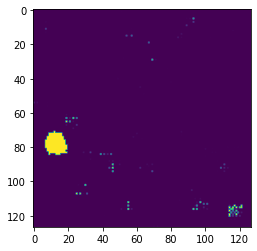

In [21]:
lenside = int(np.sqrt(len(all_pred[0])))
temp = np.reshape(all_pred[0],(lenside,lenside))
plt.imshow(temp)

In [17]:
pure_bkg_pred = np.load("diff_stepsize/100_pure_bkg_allpred_20step.npy")
bkgpSig_pred = np.load("diff_stepsize/100_bkgp_g2_n1_allpred_20step.npy")

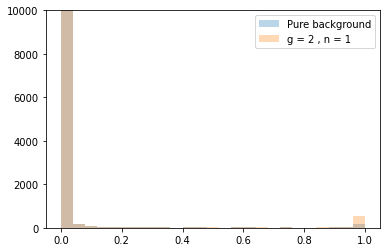

In [18]:
binsbs = np.arange(0,1.02,0.04)
n1, bins1, _ = plt.hist(pure_bkg_pred,binsbs,alpha = 0.3,density = False,label="Pure background")
n2, bins2,_ = plt.hist(bkgpSig_pred,binsbs,alpha = 0.3,density = False,label="g = 2 , n = 1")
plt.ylim(0,10000)
plt.legend()

In [19]:
np.set_printoptions(suppress=True)
np.round(n1/100)

array([1015.,    2.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    2.])

In [20]:
np.set_printoptions(suppress=True)
np.round(n2/100)

array([1011.,    2.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    6.])

In [14]:

64**2/32**2

4.0

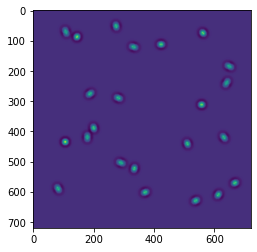

In [58]:
plt.imshow(sigs)

In [62]:
bkgpSig_pred[:-4096][bkgpSig_pred[:-4096]>0.5]

array([0.61328223, 0.72697215, 0.98188575, ..., 0.84524016, 0.71845789,
       0.94996262])

In [152]:
from scipy.special import factorial

def poisson(nzero, mu,lowerbound = 0):
    #print(mu**nzero*np.exp(-mu)/factorial(nzero))
    Pelem = mu**nzero*np.exp(-mu)/factorial(nzero)
    return Pelem[lowerbound:].sum()

In [170]:
poisson(np.round(n1/100),np.round(n2/100),24)/poisson(np.round(n1/100),np.round(n1/100),24)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in power
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


0.0050957275193796725

In [137]:
len(pure_bkg_pred[pure_bkg_pred>0.5])

1644

In [138]:
len(bkgpSig_pred[bkgpSig_pred>0.5])

7281